## Image classfication using Logistic Regression model
#### Dataset: [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)
#### Framework: Pytorch

In [6]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from random import randrange
from torchvision.utils import make_grid

In [7]:
#defining the model to be used
class CustomModel(nn.Module):
    def __init__(self, r1):
        super().__init__()
        self.r1 = r1
        self.linear = nn.Linear(self.r1.input_size, self.r1.num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, self.r1.input_size)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images) 
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = self.r1.accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [14]:
#Main class to preprocess data & train the model
class Logistic_regression():
    def __init__(self):
        print("constructor")
        
    #initialize hyperparameters
    def init_hyp(self):
        self.batch_size = 128
        self.lr = 0.01
        self.epoch = 20
        
    #get data in torch tensor        
    def get_data(self):
        self.Dataset = CIFAR10
        self.dataset = self.Dataset(root='data/', train=True, transform=transforms.ToTensor(), download=True)
        self.input_size = np.prod(self.dataset[0][0].shape)
        self.num_classes = len(self.dataset.classes)
        
    #initialize data & make torch tensors
    def init_data(self):
        self.get_data()
        self.init_hyp()
        self.model = CustomModel(self)
        
        train_ds, val_ds = random_split(self.dataset, [int(len(self.dataset)*0.8), int(len(self.dataset)*0.2)])
        self.test_ds = self.Dataset(root='data/', train=False, transform=transforms.ToTensor())

        self.train_loader = DataLoader(train_ds, self.batch_size, shuffle=True)
        self.val_loader = DataLoader(val_ds, self.batch_size*2)
        self.test_loader = DataLoader(self.test_ds, self.batch_size*2)
        
    def accuracy(self, outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    def evaluate(self, data):
        outputs = [self.model.validation_step(batch) for batch in data]
        return self.model.validation_epoch_end(outputs)

    #train the model on train data
    def fit(self, opt_func=torch.optim.SGD):
        self.history = []
        optimizer = opt_func(self.model.parameters(), self.lr)
        for e in range(self.epoch):
            for batch in self.train_loader:
                loss = self.model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Validation phase
            result = self.evaluate(self.val_loader)
            self.model.epoch_end(e, result)
            self.history.append(result)
            
    def plot_acc(self):
        accuracies = [r['val_acc'] for r in self.history]
        plt.plot(accuracies, '-x')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Accuracy vs. No. of epochs')
    
    #predict random image from test dataset
    def predict_rand_image(self):
        img_i = randrange(0, len(self.test_ds), 1)
        img, label = self.test_ds[img_i]
        print(img.shape)
        plt.imshow(img.permute(1, 2, 0))
        print('Label:', self.test_ds.classes[label], ', Predicted:', self.test_ds.classes[self.predict_image(img)])
        
    def predict_image(self,img):
        xb = img.unsqueeze(0)
        yb = self.model(xb)
        _, preds  = torch.max(yb, dim=1)
        return preds[0].item()
    
    #display a batch of random images
    def display_batch(self):
        for images, _ in self.train_loader:
            print('images.shape:', images.shape)
            plt.figure(figsize=(16,8))
            plt.axis('off')
            plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
            break

In [15]:
r1 = Logistic_regression()

constructor


In [10]:
r1.init_data()        

Using downloaded and verified file: data/cifar-10-python.tar.gz
Extracting data/cifar-10-python.tar.gz to data/


In [11]:
r1.evaluate(r1.test_loader)

{'val_loss': 2.3120198249816895, 'val_acc': 0.11484374850988388}

images.shape: torch.Size([128, 3, 32, 32])


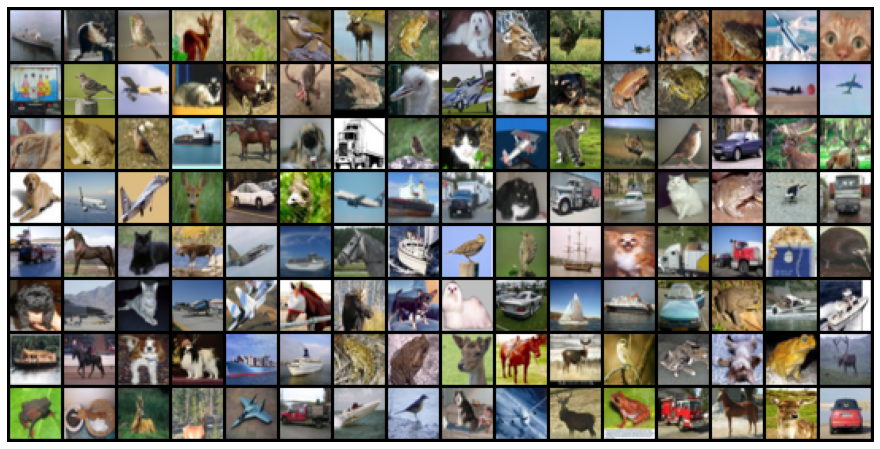

In [12]:
r1.display_batch()

In [13]:
r1.fit()

Epoch [0], val_loss: 8.3973, val_acc: 0.1986
Epoch [1], val_loss: 11.0859, val_acc: 0.2236
Epoch [2], val_loss: 9.8076, val_acc: 0.2098
Epoch [3], val_loss: 4.7481, val_acc: 0.3138
Epoch [4], val_loss: 9.1474, val_acc: 0.2426


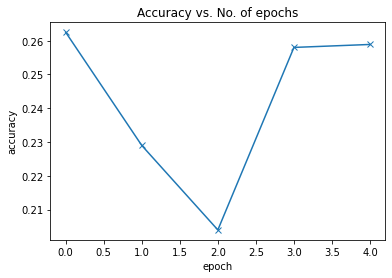

In [11]:
r1.plot_acc()

In [12]:
r1.evaluate(r1.test_loader)

{'val_loss': 7.916943550109863, 'val_acc': 0.26093751192092896}

torch.Size([3, 32, 32])
Label: automobile , Predicted: automobile


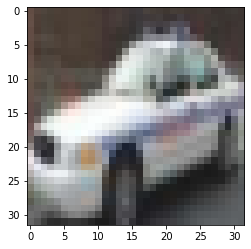

In [15]:
r1.predict_rand_image()